<a href="https://colab.research.google.com/github/KKhushhalR2405/Identifying-the-dance-form/blob/master/DanceForm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
%cd /content/drive/My Drive/Dance

/content/drive/My Drive/Dance


In [0]:
import numpy as np
from glob import glob

In [0]:
import os
from torchvision import datasets


from torchvision import datasets
import torchvision.transforms as transforms
import torch
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True



batch_size = 10
num_workers = 0

data_dir = '/content/drive/My Drive/Dance'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'val/')


In [0]:
standard_normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     standard_normalization]),
                   'val': transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     standard_normalization])}

In [0]:
train_data = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transforms['val'])

In [0]:
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)

In [0]:
loaders_scratch = {
    'train': train_loader,
    'valid': valid_loader}

In [0]:
loaders_transfer = loaders_scratch.copy()


use_cuda = torch.cuda.is_available()



In [0]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = False
    
model_transfer.fc = nn.Linear(2048, 8, bias=True)


fc_parameters = model_transfer.fc.parameters()


for param in fc_parameters:
    param.requires_grad = True


if use_cuda:
    model_transfer = model_transfer.cuda()

In [91]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001)

In [0]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # initialize weights to zero
            optimizer.zero_grad()
            
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [94]:
train(100, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch 1, Batch 1 loss: 2.264106
Epoch: 1 	Training Loss: 2.072664 	Validation Loss: 2.024592
Validation loss decreased (inf --> 2.024592).  Saving model ...
Epoch 2, Batch 1 loss: 2.035564
Epoch: 2 	Training Loss: 2.017416 	Validation Loss: 1.951295
Validation loss decreased (2.024592 --> 1.951295).  Saving model ...
Epoch 3, Batch 1 loss: 1.923394
Epoch: 3 	Training Loss: 1.953388 	Validation Loss: 1.886986
Validation loss decreased (1.951295 --> 1.886986).  Saving model ...
Epoch 4, Batch 1 loss: 1.939763
Epoch: 4 	Training Loss: 1.903769 	Validation Loss: 1.823804
Validation loss decreased (1.886986 --> 1.823804).  Saving model ...
Epoch 5, Batch 1 loss: 1.715144
Epoch: 5 	Training Loss: 1.854479 	Validation Loss: 1.764982
Validation loss decreased (1.823804 --> 1.764982).  Saving model ...
Epoch 6, Batch 1 loss: 1.873369
Epoch: 6 	Training Loss: 1.827130 	Validation Loss: 1.717297
Validation loss decreased (1.764982 --> 1.717297).  Saving model ...
Epoch 7, Batch 1 loss: 1.782487
E

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [95]:
class_names = loaders_transfer['train'].dataset.classes
print(class_names)

['bharatanatyam', 'kathak', 'kathakali', 'kuchipudi', 'manipuri', 'mohiniyattam', 'odissi', 'sattriya']


In [0]:
from PIL import Image
import torchvision.transforms as transforms

def load_input_image(img_path):    
    image = Image.open(img_path).convert('RGB')
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     standard_normalization])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [0]:
def predict_breed_transfer(model, class_names, img_path):
    # load the image and return the predicted breed
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

In [0]:
import matplotlib.pyplot as plt                        
%matplotlib inline  

def run_app(img_path):
    
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    
    prediction = predict_breed_transfer(model_transfer, class_names, img_path)
        
    return prediction
    

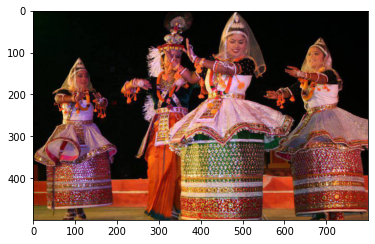

'manipuri'

In [119]:
run_app("/content/drive/My Drive/Dance/test/108.jpg")

In [100]:
import csv

src_dir = "/content/drive/My Drive/Dance/test/"

rows=[]
with open('/content/drive/My Drive/Dance/test/test.csv', 'r') as file:
    reader = csv.reader(file)
    for i,row in enumerate(reader):
        if i != 0:
            rows.append([row[0],run_app(src_dir+row[0])])
print(rows)


            

[['508.jpg', 'kuchipudi'], ['246.jpg', 'mohiniyattam'], ['473.jpg', 'odissi'], ['485.jpg', 'kuchipudi'], ['128.jpg', 'bharatanatyam'], ['410.jpg', 'kuchipudi'], ['465.jpg', 'bharatanatyam'], ['196.jpg', 'kathakali'], ['340.jpg', 'sattriya'], ['467.jpg', 'kathak'], ['306.jpg', 'mohiniyattam'], ['171.jpg', 'bharatanatyam'], ['323.jpg', 'sattriya'], ['332.jpg', 'sattriya'], ['330.jpg', 'kathak'], ['170.jpg', 'bharatanatyam'], ['479.jpg', 'odissi'], ['9.jpg', 'kathak'], ['283.jpg', 'mohiniyattam'], ['114.jpg', 'bharatanatyam'], ['507.jpg', 'odissi'], ['183.jpg', 'kathakali'], ['200.jpg', 'kathakali'], ['457.jpg', 'odissi'], ['264.jpg', 'mohiniyattam'], ['194.jpg', 'kathakali'], ['518.jpg', 'odissi'], ['175.jpg', 'bharatanatyam'], ['64.jpg', 'kathak'], ['152.jpg', 'bharatanatyam'], ['270.jpg', 'mohiniyattam'], ['125.jpg', 'bharatanatyam'], ['38.jpg', 'kathak'], ['440.jpg', 'kuchipudi'], ['302.jpg', 'mohiniyattam'], ['394.jpg', 'kuchipudi'], ['448.jpg', 'odissi'], ['463.jpg', 'odissi'], ['20

In [0]:
fields = ['Image','target']

filename = "dance_output.csv"


    

with open(filename, 'w') as csvfile:  
      
    csvwriter = csv.writer(csvfile)  
        
      
    csvwriter.writerow(fields)  
        
     
    csvwriter.writerows(rows) 